<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/kitti_tracker/1_kitti_object_detection_lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KITTI 3D Object Detection - LiDAR**

In this tutorial we will dive into the KITTI dataset and detect objects in 3D using camera images to detect objects in 2D and we will wugment with LiDAR data to provide the depth info to give us 3D perspective. Since we are considering a simple autonomous vehicle situation we will consider the vertical axis (i.e. height or altitude) to be 0. This will make things a bit easier to think about.

<br>

For more information a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT), and a paper that details the data collection and coordinate systems can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf). 

<br>

Now let's get the data and get started.

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-09-09 13:54:41--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.77
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  11.3MB/s    in 4m 25s  

2022-09-09 13:59:07 (11.2 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-09-09 13:59:07--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.219
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-09-09 13:59:08 (134 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [3]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

## Base Library Import

In [111]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Import KITTI Utility functions

In [127]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

--2022-09-09 16:36:43--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2022-09-09 16:36:43--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7281 (7.1K) [text/plain]
Saving to: ‘kitti_utils.py’

kitti_utils.py      100%[===================>]   7.11K  --.-KB/s    in 0s      

2022-09-09 16:36:44 (35.4 MB/s) - ‘kitti_utils.py’ saved [7281/7281]



## Data Overview

In the KITTI raw dataset we get images from four cameras (two grayscale and two RGB), the velodyne LiDAR, and the OXTS GPS navigation system. 

The update rates are as follows:
- RGB camera: 15 Hz (15 fps)
- OXTS GPS navigation system: 100Hz
- Velodyne LiDAR: 10Hz 

The data is synched to the LiDAR, since it has the lowest update rate, but the sync between the camera, GPS/IMU, and LiDAR is not precise (even though we are using the synched raw data!). Per the KITTI [description](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) the worst time difference between the camera/velodyne and gps/imu is at most 5ms. More precise measurements can be obtained with interpolation, but for simplicity we will neglect these differences since the small error from the imprecise sync will not greatly impact our measurements.

<br>
<br>


Now let's get the paths to all of the datafiles, the RGB images are standard .png's, but the LiDAR point clouds are binary files. The [KITTI README](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT) describes the structure of the binary files, and we will import a utility function to handle them.

In [225]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


## **Camera/LiDAR Calibration Data**

The camera and LiDAR have different reference frames:

- camera
  - x &#8594; right
  - y &#8594; down
  - z &#8594; forward
- LiDAR
  - x &#8594; forward
  - y &#8594; left
  - z &#8594; up



  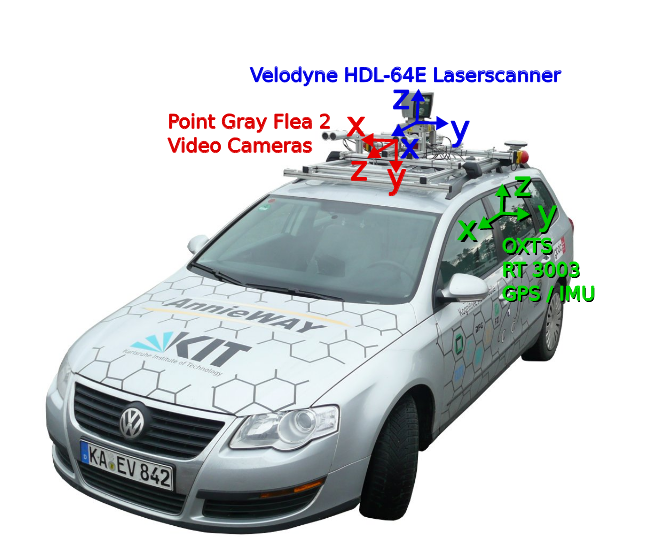

In order to convert a point from the LiDAR to the camera, we must perform three transformations on the point.

The first transformation converts the point to the LiDAR frame of reference via [rigid body transformation](https://www.seas.upenn.edu/~meam620/slides/kinematics0.pdf), which takes into account the rotation and translation of the axes. A rigid transformation has two main componenents a rotation and a translation. A rigid transformation matrix can combine these two components like so:

$$
    T = \begin{bmatrix}
            r_{11} & r_{12} & r_{13} & t_{14} \\ 
            r_{21} & r_{22} & r_{23} & t_{24} \\ 
            r_{31} & r_{32} & r_{33} & t_{34} 
        \end{bmatrix}
$$

Where the r's correspond to the 3x3 rotation matrix and the t's correspond to the 3x1 translation vector.

Next we perform the [rectifying transformation](https://en.wikipedia.org/wiki/Image_rectification). We need the rectifying transformtion since we are working the stereo images that are references to the same y-axis (i.e. an object on left image has the same y-coordinate as the right image, but not the necissarily the same x-coordinate). When a pair of stereo images are referenced to the same y-axis we call them rectified.

Finally we apply the projection transformation on the point, which gives us the location of a 3D point in 2D image space.

<br>

#### **LiDAR to Camera Summary**
We can combine these three transformation into a single transformation matrix that will perform the LiDAR to Camera tranformation in a single operation. The LiDAR to Camera translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space using the [homogeneous representation](https://en.wikipedia.org/wiki/Homogeneous_coordinates), where the $\tilde{}$ denotes a homogeneous vector.

$$ \tilde{y} = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} \tilde{x},
  \qquad \text{where } x = [x, y, z, 1]^T $$

$$ \tilde{y} = \left( \tilde{u}, \tilde{v}, z, 1 \right) $$

For conveinience we will denote:
$$ T^{uvz}_{velo} = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} $$

In order to transform from homogeneous image coordinates $\tilde{y}$ to true (u, v, z) image coordinates y, we will need to normalize by the depth and drop the 1, like so:

$$ y = \left( \frac{\tilde{u}}{z}, \frac{\tilde{v}}{z}, z \right) $$

NOTE:
- The notation convention is that the starting refence frame is in the subscript and the ending reference frame is in the superscript
- The '1' added as the 4th coordinate in homogeneous representation is sometimes referred to as 'w'

We will opt to translate all points to the left image 

<br>
<br>

## **Camera to LiDAR**

To transform Camera (u,v,z) (where in this case z will be LiDAR depth in meters) we will need to follow a few steps.

First we need to convert $T^{uvz}_{velo}$ to it's homogeneous representation, we can do that by adding a row of new coordinates on the bottom, where 0's will be placed under the rotation portion and a 1 will be placed under the translation portion.

$$ T^{uvz}_{velo} = \begin{bmatrix}
                     t_{11} & t_{12} & t_{13} & t_{14} \\ 
                     t_{21} & t_{22} & t_{23} & t_{24} \\ 
                     t_{31} & t_{32} & t_{33} & t_{34} \\ 
                          0 &      0 &      0 & 1      \\ 
                    \end{bmatrix}
$$

Next we need to convert $y$ back to it's homogeneous form $\tilde{y}$

$$ \tilde{y} = (u \cdot z,\; v \cdot z,\; z,\; 1) $$

and finally we can get the homogeneous representation in LiDAR coordinates

$$ (T^{uvz}_{velo})^{-1} \tilde{y} = \tilde{x} $$

## **IMU to LiDAR**

We will also need to translate IMU to LiDAR, thankfully we have a single matrix $T^{velo}_{imu}$ that will handle this in a single operation.

$$y_{velo} = T^{velo}_{imu} x_{imu}$$

And once we have $y_{velo}$ we can convert it to camera coordiantes using the equations above, or we can compose the transformations:

$$ 
    T^{uvz}_{imu} = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} T^{velo}_{imu}
$$

To transform from the Camera to IMU coordiantes, we can do a very similar operation as we did for camera to LiDAR. We just use the homogeneous representation of the transformation matrix and take it's inverse, then we can invert the transform.

<br>
<br>

## **Load Camera Calibration Data**


In [132]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [133]:
# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

## **Load LiDAR and GPS/IMU Calibration Data**

In [134]:
T_cam_velo = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_velo_imu = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

Obtain matrix to transform 3D LiDAR/velo (x, y, z) coordiantes to 2D camera (u,v) coordinates, and it's homogeneous inverse that will allow us to transform from camera (u, v, z, 1) back to LiDAR (x, y, z, 1)

In [138]:
# transform from velo (LiDAR) to left color camera
T_uvz_velo = P_left @ R_left_rect @ T_cam_velo

# transform from left color camera to velo (LiDAR)
T_uvz_velo_inv = np.linalg.inv(np.insert(T_uvz_velo, 3, values=[0,0,0,1], axis=0)) 

Now we can get the transformation matrix for IMU to camera and cmaera to IMU

In [139]:
# transform from IMU to left color camera
T_uvz_imu = T_uvz_velo @ T_velo_imu

# transform from left color camera to IMU
T_uvz_imu_inv = np.linalg.inv(np.insert(T_uvz_imu, 3, values=[0,0,0,1], axis=0)) 

Now that we are able to project the LiDAR points onto the image, we can associate points on the image with LiDAR depth. We will use YOLOv5 to detect objects in 2D, then we will find their corresponding depths. Then using our GPS/IMU data we can find out where all of these objects are located in the world via Latitude and Longitude.

<br>

## **Get Object Detection Pipeline**

In [26]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12219, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 12219 (delta 6), reused 11 (delta 4), pack-reused 12197
Receiving objects: 100% (12219/12219), 12.61 MiB | 22.08 MiB/s, done.
Resolving deltas: 100% (8410/8410), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [144]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-9-9 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [145]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## **Detection Pipeline**

Now we can define the main pipeline to get the detections and their center coordinates in multiple reference frames. We will get the object centers in:
- Camera (u, v, z)
- LiDAR (x, y, z)
- IMU (x, y, z)

In [217]:
def get_transformed_coordinates(image, velo_uvz, bboxes, draw=True):
    ''' Obtains transformed coordinates for each of the detected objects
            LiDAR uvz  
            LiDAR xyz
            IMU xyz 
            Latitude/Longitude and Altitude
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the desired
        references and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection 
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          coordinates - array containing the object centers at each coordinate
                        reference
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    coordinates = np.zeros((bboxes.shape[0], 9))

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([v[min_loc], u[min_loc], velo_depth])

        # convert uvz location to LiDAR xyz coordinate frame
        uvzw_location = np.hstack((uvz_location[:2] * uvz_location[2],
                                   uvz_location[2],
                                   1))[:, None]
        velo_xyzw = T_uvz_velo_inv @ uvzw_location

        # convert uvz location to IMU coordinate frame
        imu_xyzw = T_uvz_imu_inv @ uvzw_location

        # convert IMU to Latitude/Longitude and Altitude
        

        # add velo (u, v, z) to coordinates
        coordinates[i, 0:3] = uvz_location

        # add velo (x, y, z) to bboxes
        coordinates[i, 3:6] = velo_xyzw[:3].squeeze()

        # add IMU (x, y, z) to coordinates
        coordinates[i, 6:9] = imu_xyzw[:3].squeeze()

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), 
                             np.round(obj_x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return coordinates


In [218]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of 
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz 
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path, 
                                   T_uvz_velo, 
                                   left_image, 
                                   remove_plane=True)

    # get distance measurements for image
    coordinates = get_transformed_coordinates(image, 
                                              velo_uvz, 
                                              bboxes, 
                                              draw=draw_depth)

    return bboxes, velo_uvz, coordinates

In [219]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]

bboxes, velo_uvz, coordinates =get_detection_coordinates(left_image, 
                                                         bin_path)

In [220]:
# plotting functions (place these in KITTI plot utils
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_uvz, image, color_map=get_color):
   
    # unpack LiDAR points
    u, v, z = velo_uvz

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(image, (int(u[i]), int(v[i])), 1, 
                   color_map(z[i]), -1);

    return image

In [221]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

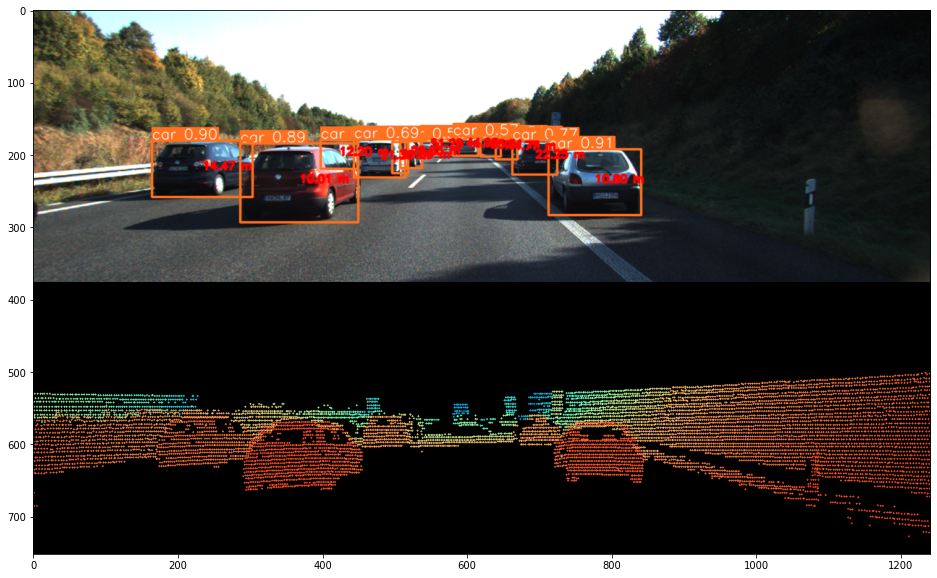

In [222]:
# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

In [223]:
coordinates

array([[     238.08,      774.83,      10.795,      11.031,      5.7574,      -8.869,      11.819,      5.3265,     -8.1731],
       [     221.77,      232.79,      14.471,       14.72,      7.8867,    -0.95488,      15.523,      7.5757,    -0.29892],
       [     239.28,      369.03,      10.007,      10.263,      5.2497,     -2.5774,      11.064,      4.9116,     -1.8731],
       [     201.81,      694.62,      22.251,      22.433,      12.905,     -15.723,      23.201,      12.381,     -15.156],
       [     204.56,      479.06,      21.357,      21.563,      12.223,     -8.6914,      22.346,      11.802,     -8.1127],
       [     189.15,       600.5,      44.979,      45.067,      26.753,     -25.827,      45.804,      26.094,      -25.51],
       [     201.13,      522.04,      28.847,      29.019,      16.653,     -13.443,      29.789,      16.167,     -12.945],
       [     189.52,      632.09,      55.511,      55.546,      33.009,     -34.301,      56.261,      32.232,     -3

#### Now that we can detect objects and get their deths as measured by LiDAR, let's move on to fidning their Lat/Lon locations in the world. This means we will need to take the (x, y, z) IMU coordinates located at the final three columns of bboxes_out and use the vehicle Lat/Lon/Alt to convert them to Latitude and Longitude.

<br>

So now we will add GPS/IMU navigation data to our pipeline. For simplicity we will only consider the 2D case since we are on the ground and our range is not long enough to take into account the earth's curvature. In other words we are doing one of my favorite things, which pretending that the earth is flat!

To use the navigation data we will need to orient the vehicle using the heading.

Now we need to convert the object IMU (x, y, z) coordinates to Azimuth, Elevation, and Range. Then we can use navpy to convert the object centers to Latitude, Longitude, and Altitude. For the altitude the KITTI dataset does not specify what type of altitude, but the [OXTS documentation](https://www.oxts.com/wp-content/uploads/2020/03/rtman-200302.pdf) states that it can measure either geoidal (MSL) or ellipsoidal (HAE), for details see [this](https://support.pix4d.com/hc/en-us/articles/202559869-Orthometric-vs-ellipsoidal-height). We will go ahead and assume that altitude doesn't matter

In [ ]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

bboxes, velo_uvz, coordinates = get_detection_coordinates(left_image, 
                                                          bin_path)

In [227]:
oxts_frame = get_oxts(oxts_paths[index])

In [244]:
lat = oxts_frame[0]
lon = oxts_frame[1]
alt = oxts_frame[2]

lat, lon, alt

(48.950363327816, 8.4873099619548, 270.12783813477)

In [265]:
# convert x,y,z to Az, El , Range
x, y, z = coordinates[-2, 6:]
x, y, z

(45.57772980537404, 25.694088401124038, -28.81438763388239)

In [266]:
rng = np.sqrt(x**2 + y**2 + z**2)
az = np.degrees(np.arctan2(y, x))
el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z))

# these are in degrees
rng, az, el

(59.73093476325389, 29.41178963008787, 118.84246972798736)

In [230]:
!pip install pymap3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.3 MB/s 


In [267]:
import pymap3d as pm

pm.aer2geodetic(az, el, rng, lat, lon, alt)

(48.95013763223242, 8.487116780448, 322.44917647332)

In [249]:
pm.aer2geodetic(az, el, rng, lat, lon, alt)

(48.95029632772135, 8.487264114713732, 283.0913896521962)

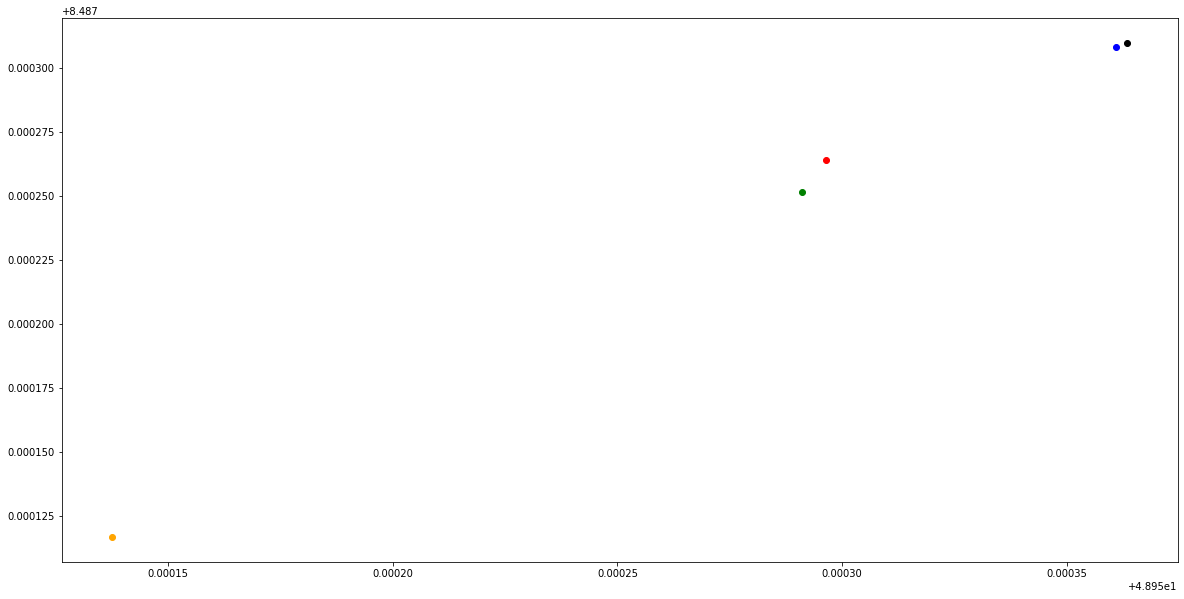

In [268]:
plt.scatter(lat, lon, color='black')
plt.scatter(48.95029632772135, 8.487264114713732, color='red')
plt.scatter(48.95036091230588, 8.487308172046165, color='blue')
plt.scatter(48.95029100613406, 8.487251834746033, color='green')
plt.scatter(48.95013763223242, 8.487116780448, color='orange')